# Python vs Matlab calibration comparison

## Objective: compare calibration checkerboard detection in python (opencv) & matlab (toolbox)

### Test 1: single image, intrinsic camera calibration

In [68]:
import numpy as np
import cv2
from cv2 import aruco
import glob
import time
import pandas as pd

from scipy.io import loadmat, savemat
from src.calibration.new.utils import get_chessboard_coordinates, imshow
        
# extra imports
import os
import matplotlib.pyplot as plt

In [69]:
# interactive plot widgit:
%matplotlib widget

In [70]:
# test parameters

rows = 6
cols = 9
square_size_mm = 23

width = 1920
height = 1200

# note: in this case frame_id is a string with 4 digits, leading zeros if necessary
# frame_id: str = '0034'
# camera_name: str = 'Camera 4'
# 1: cam1, f34
# 2: cam4, f17
frames = [
    '0001','0002', '0006','0007', '0008','0009', '0010', '0011', '0012', '0013'
]

f = lambda frame: f'/Users/caxon/olveczky/dannce_data/setupCal11_010324/Intrinsics/Camera 4/Basler_a2A1920-160ucPRO__40125727__20240103_153235585_{frame}.tiff'

image_paths = [f(fr) for fr in frames]

# disable for mlutiple images
show_img = False

objpoints = get_chessboard_coordinates(chessboard_rows=rows,
           chessboard_cols=cols, square_size_mm=square_size_mm)

all_raw_images = []
# load raw image(s)
for image_path in image_paths:
    raw_image = np.zeros((height, width, 3), dtype=np.uint8)
    raw_image = cv2.imread(image_path)
    all_raw_images.append(raw_image)

print("ALL IMAGES LOADED", len(all_raw_images))

all_imgpoints = []
all_objpoints = []

for i in range(len(all_raw_images)):
    # find points
    this_img = all_raw_images[i][:,:,:].copy()
    gray = cv2.cvtColor(this_img, cv2.COLOR_BGR2GRAY)
    success, corner_coords = cv2.findChessboardCorners(gray, (cols,rows), None)
    
    if success == True:     
        print(f"#{i}[{frames[i]}]: SUCCESS")
        imgpoints = corner_coords
        all_imgpoints.append(imgpoints)
        all_objpoints.append(objpoints)
        if show_img is True:
            cv2.drawChessboardCorners(this_img, (cols,rows), corner_coords, True)
            imshow(this_img)
    else:
        print(f"#{i}[{frames[i]}]: FAILURE")

imgpoints = imgpoints.squeeze()

# check the shapes of resulting points
print("OBJ POINTS SHAPE:", objpoints.shape)
print("IMG POINTS SHAPE:", imgpoints.shape)

ALL IMAGES LOADED 10
#0[0001]: SUCCESS
#1[0002]: SUCCESS
#2[0006]: SUCCESS
#3[0007]: SUCCESS
#4[0008]: SUCCESS
#5[0009]: SUCCESS
#6[0010]: SUCCESS
#7[0011]: SUCCESS
#8[0012]: SUCCESS
#9[0013]: SUCCESS
OBJ POINTS SHAPE: (54, 3)
IMG POINTS SHAPE: (54, 2)


In [71]:
rpe, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(all_objpoints, all_imgpoints, gray.shape[::-1] , None, None, flags=cv2.CALIB_FIX_K3)

np.set_printoptions(suppress=True, precision=4)

print(f"error: {rpe}\n")
print(f"mtx:\n{mtx}\n")
print(f"dist (k1, k2, p1, p2, k3?):\n{dist.squeeze()}\n")
print(f"rvecs[0]: {rvecs[0].squeeze()}\n")
print(f"tvecs[0]: {tvecs[0].squeeze()}\n")

rmats = []
for rvec in rvecs:
    rmat, _jac = cv2.Rodrigues(rvec)
    rmats.append(rmat)
print(f"revec rot. matrix[0]:\n{rmats[0]}\n")

error: 0.35415975354924323

mtx:
[[2306.906     0.      924.7987]
 [   0.     2308.1366  579.6354]
 [   0.        0.        1.    ]]

dist (k1, k2, p1, p2, k3?):
[-0.0669  0.106  -0.0012 -0.0043  0.    ]

rvecs[0]: [ 0.1618 -0.1558  0.039 ]

tvecs[0]: [-103.1465   14.9016  909.8542]

revec rot. matrix[0]:
[[ 0.9872 -0.0512 -0.1513]
 [ 0.0261  0.9862 -0.1634]
 [ 0.1576  0.1573  0.9749]]



In [72]:
# load calibration session points from matlab:

matfile = loadmat("/Users/caxon/olveczky/newsdannce/calibFromMatlabCam4.mat")
mat_mtx = matfile.get("intrinsicMatrix")
mat_dist = matfile.get("distortionCoefficients")
mat_tvecs = [x[0].reshape((3,1)) for x in (matfile.get("t_vecs"))]
mat_rmats = [x[0] for x in matfile.get("r_mats")]

/Users/caxon/miniforge3/envs/dannce-dev/lib/python3.11/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [73]:
mat_rmats

[array([[ 0.9864, -0.0526, -0.1557],
        [ 0.0262,  0.9857, -0.1666],
        [ 0.1622,  0.1602,  0.9737]]),
 array([[ 0.982 , -0.1106, -0.1534],
        [ 0.0793,  0.9772, -0.1971],
        [ 0.1717,  0.1814,  0.9683]]),
 array([[ 0.9749, -0.131 , -0.1801],
        [ 0.0878,  0.9692, -0.23  ],
        [ 0.2047,  0.2084,  0.9564]]),
 array([[ 0.9853, -0.0951, -0.1417],
        [ 0.0658,  0.9779, -0.1985],
        [ 0.1575,  0.1863,  0.9698]]),
 array([[ 0.9921, -0.0531, -0.114 ],
        [ 0.0317,  0.9827, -0.1825],
        [ 0.1218,  0.1775,  0.9766]]),
 array([[ 0.988 , -0.0661, -0.1399],
        [ 0.0401,  0.9826, -0.1811],
        [ 0.1494,  0.1734,  0.9735]]),
 array([[ 0.9824, -0.0539, -0.1786],
        [ 0.015 ,  0.977 , -0.2128],
        [ 0.186 ,  0.2064,  0.9606]]),
 array([[ 0.9985,  0.0065, -0.0539],
        [-0.0102,  0.9975, -0.0704],
        [ 0.0533,  0.0708,  0.9961]]),
 array([[ 0.8068, -0.1006,  0.5822],
        [ 0.172 ,  0.9827, -0.0685],
        [-0.5652,  0.1

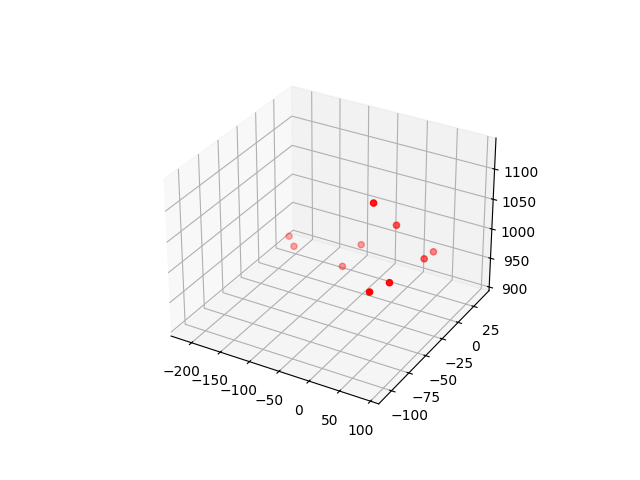

In [74]:
# python values
x1 = [p[0][0] for p in tvecs]
y1 = [p[1][0] for p in tvecs]
z1 = [p[2][0] for p in tvecs]

# matlab values
x2 = [p[0][0] for p in mat_tvecs]
y2 = [p[1][0] for p in mat_tvecs]
x2 = [p[2][0] for p in mat_tvecs]

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(xs=x1, ys=y1, zs=z1, c='red')